## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.8.*"

my_query = {}

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import time

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS='pic'
destSiteOWDServer = "193.109.172.188"
#destSiteThroughputServer = "193.109.172.187"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170802T000000Z', 'lt': '20170810T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                #{'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                #{'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))


In [4]:
#site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
site = {srcSiteOWDServer: sS, destSiteOWDServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
print(epoch)

for res in scroll:
    if count<10: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
#    if column_type == 'latency':
#        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
#        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
#        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    if column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
#    elif column_type == 'throughput':
#        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
#    elif column_type == 'traceroute':
#        data[s].set_value( ts, 'hash', res['_source']['hash'])
    if count<2: print(dt)

1970-01-01 00:00:00
{'_score': None, 'sort': [662], '_id': 'AV2_JpDONILXDji8tU3c', '_source': {'MA': '128.142.223.247', 'srcSite': 'CERN-PROD', 'timestamp': 1502150417000, 'src': '128.142.223.247', 'dest_host': 'psl01.pic.es', 'dest': '193.109.172.188', 'srcProduction': True, 'destVO': 'ATLAS', 'destSite': 'pic', 'ipv6': False, 'src_host': 'perfsonar-lt.cern.ch', 'srcVO': 'ATLAS', 'destProduction': True, 'packet_loss': 0.0}, '_type': 'packet_loss_rate', '_index': 'network_weather-2017.8.8'}
2017-08-08 00:00:17
{'_score': None, 'sort': [960], '_id': 'AV2_JqhONILXDji8tWdx', '_source': {'MA': '128.142.223.247', 'srcSite': 'CERN-PROD', 'timestamp': 1502150477000, 'delay_median': 15.05, 'delay_sd': 0.10844696476465665, 'dest_host': 'psl01.pic.es', 'dest': '193.109.172.188', 'srcProduction': True, 'destVO': 'ATLAS', 'destSite': 'pic', 'ipv6': False, 'src_host': 'perfsonar-lt.cern.ch', 'srcVO': 'ATLAS', 'destProduction': True, 'src': '128.142.223.247', 'delay_mean': 15.080649999999999}, '_typ

In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

#data[dS].sort_index(inplace=True) 
#data[dS].describe()

print(data[sS])

                       timestamp  packet_loss
1.501632e+12 2017-08-02 00:00:41     0.000000
1.501632e+12 2017-08-02 00:00:58     0.000000
1.501632e+12 2017-08-02 00:01:41     0.000000
1.501632e+12 2017-08-02 00:01:58     0.000000
1.501632e+12 2017-08-02 00:02:41     0.000000
1.501632e+12 2017-08-02 00:02:58     0.000000
1.501632e+12 2017-08-02 00:03:41     0.000000
1.501632e+12 2017-08-02 00:03:58     0.000000
1.501632e+12 2017-08-02 00:04:42     0.000000
1.501632e+12 2017-08-02 00:04:59     0.000000
1.501632e+12 2017-08-02 00:05:16          NaN
1.501632e+12 2017-08-02 00:05:42     0.000000
1.501632e+12 2017-08-02 00:05:59     0.000000
1.501632e+12 2017-08-02 00:06:47     0.000000
1.501632e+12 2017-08-02 00:06:59     0.000000
1.501632e+12 2017-08-02 00:07:52     0.000000
1.501632e+12 2017-08-02 00:07:59     0.000000
1.501633e+12 2017-08-02 00:08:52     0.000000
1.501633e+12 2017-08-02 00:08:59     0.000000
1.501633e+12 2017-08-02 00:09:22          NaN
1.501633e+12 2017-08-02 00:09:52  

### Extract values

In [6]:
F = data[sS]
#B = data[dS]
#Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
#Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
#Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
#Fd = F[F.delay_mean<150]
#Bd = B[B.delay_mean<150]
#Jd = Fd.join(Bd,how='inner', rsuffix="_back")
#Jd['dmean']= (Jd.delay_mean + Jd.delay_mean_back)/2

#Fh = F[F.hash.notnull()]
#Bh = B[B.hash.notnull()]
Fids=[];Bids=[]
Fu=[];Bu=[]

#for fi in Fh.hash.tolist():
#    if fi not in Fu: Fu.append(fi)
#    Fids.append(Fu.index(fi))
#for fi in Bh.hash.tolist():
#    if fi not in Bu: Bu.append(fi)
#    Bids.append(Bu.index(fi))

#### interpolate all the values and leave only onese where all 4 measurements are there

In [7]:
NF=F.interpolate(method='index',limit=1,limit_direction='both')
#NFall = NF[NF.throughput.notnull()]
#NFall = NFall[NFall.delay_mean.notnull()]
NFall = NF[NF.packet_loss.notnull()]
#NFall = NFall[NFall.hash.notnull()]

#NB=B.interpolate(method='index',limit=1,limit_direction='both')
#NBal = NB[NB.throughput.notnull()]
#NBall = NB[NB.delay_mean.notnull()]
#NBall = NB[NB.packet_loss.notnull()]
print(NFall.shape)

(23226, 2)


In [8]:
#print(NF)
#print(NB)

print(NF.shape)
#print(NB.shape)

(23229, 2)


In [9]:
#print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
#print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
print( 'packet loss forward: ', Fpl.shape[0])
#print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
#print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])

#i=0
#while i < Fpl.shape[0]:
#    print("Hi")
#    i = i + 1

packet loss forward:  22332


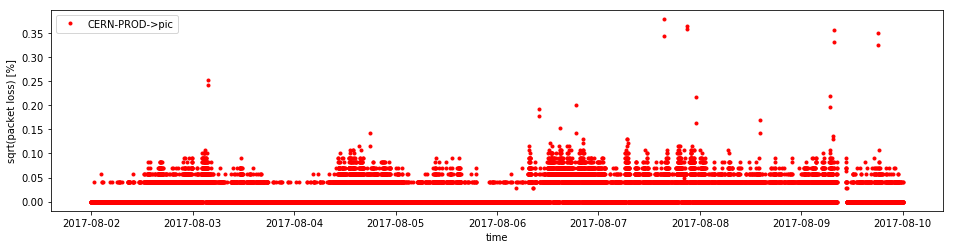

In [10]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

#ax0 = plt.subplot(gs[0])
#ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
#ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
#ax0.set_xlabel('time')
#ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#ax0.xlim(xmin=0)
#ax0.legend()

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
#ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

#ax4 = plt.subplot(gs[2])
#ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
#ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
#ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
#ax4.set_xlabel('time')
#ax4.set_ylabel('one way delay [ms]')
#ax4.legend()

#ax6 = plt.subplot(gs[3])
#ax6.plot(Fh.timestamp.tolist(), Fids, ls='', marker='.', c='r', label=sS+'->'+dS)
#ax6.plot(Bh.timestamp.tolist(), Bids, ls='', marker='.', c='b', label=dS+'->'+sS)
#ax6.set_xlabel('time')
#ax6.set_ylabel('path index')
#ax6.legend()

#plt.savefig('Plots/4PlotForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

### Boosted Decision Trees

In [11]:
start_time = time.clock()

# clf = AdaBoostClassifier(n_estimators=100)
# y=df.Flag
# X=df.loc[:,range(n_series)]
# scores = cross_val_score(clf, X, y)
# print(scores)
predicted_flag_array = np.zeros((24*3600), dtype=np.int)
auc_score_array = np.zeros((24*3600), dtype=np.float)
score_holder_array = np.zeros(3600, dtype=np.float)
anomaly_array = np.ones(3600, dtype=np.int)
not_anomaly_array = np.zeros(3600, dtype=np.int)

#print df

#trying to print out the columns where the flag is 1

#if (df.iloc[ 2:, -1:] == 1):
#    print df
#print df.iloc[ :, -1:]
#if(df.iloc[-1] == 1):
#    print df


In [12]:
#separate data into Reference and Subject
def trainer(reference, subject, n_series):
    refTrainSize = (int)(reference.shape[0] * 0.7) #training size of reference data is 70% of the data
    subTrainSize = (int)(subject.shape[0] * 0.7) #training size of subject data is 70% of the data
    
    reference.loc[:].Flag = 0 # Flagging the reference data as 0
    X_ref = reference.loc[:, range(n_series)] #refers to the feature set data
    y_ref = reference.Flag #refers to the label data
    
    subject.loc[:].Flag = 1 # Flagging the subject data as 1
    X_sub = subject.loc[:, range(n_series)] #refers to the feature set data
    y_sub = subject.Flag #refers to the label data

    #separate Reference into Train and Test
    X_ref_train = X_ref.loc[:refTrainSize, range(n_series)] #take 70% of the reference feature data
    X_ref_test  = X_ref.loc[refTrainSize:, range(n_series)] #take 30% of the reference feature data
    y_ref_train = y_ref.loc[:refTrainSize] #take 70% of the reference label data
    y_ref_test  = y_ref.loc[refTrainSize:] #take 30% of the reference label data

    #separate Subject into Train and Test
    X_sub_train = X_sub.loc[:subTrainSize, range(n_series)] #take 70% of the subject feature data
    X_sub_test  = X_sub.loc[subTrainSize:, range(n_series)] #take 30% of the subject feature data
    y_sub_train = y_sub.loc[:subTrainSize] #take 70% of the subject label data
    y_sub_test  = y_sub.loc[subTrainSize:] #take 30% of the subject label data

    #Combine reference and subject train datasets
    X_train_frames = [X_ref_train, X_sub_train] 
    X_train = pd.concat(X_train_frames, ignore_index=True) #combine the 70% training data features from both reference and subject
    
    y_train_frames = [y_ref_train, y_sub_train]
    y_train = pd.concat(y_train_frames, ignore_index=True) #combine the 70% training data label from both reference and subject

    #Combine reference and subject test datasets
    X_test_frames = [X_ref_test, X_sub_test]
    X_test = pd.concat(X_test_frames, ignore_index=True) #combine the 30% training data features from both reference and subject
    
    y_test_frames = [y_ref_test, y_sub_test]
    y_test = pd.concat(y_test_frames, ignore_index=True) #combine the 30% training data label from both reference and subject

    #Train model using the combined train data
    clf = AdaBoostClassifier(n_estimators=50)
    clf.fit(X_train, y_train) 
    #train an AdaBoost model to be able to tell the difference between the reference and subject data

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    #use the trained AdaBoost model on the testing data. This is the predicted result
        
    from sklearn.metrics import roc_curve, auc
        
    #Calculate the AUC
        
    #from sklearn.preprocessing import LabelBinarizer

    # convert False and True to 0 and 1
    #lb = LabelBinarizer()
    #y_test_transformed = lb.fit_transform(y_test)
    #y_predict_transformed = lb.fit_transform(y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    #if (auc_score != 0.5):
    #    auc_score = 1.0
    
    score_holder_array.fill(auc_score)
    #print ("score_holder_array = ", score_holder_array)
    print ("auc_score = ", auc_score) #finds the auc score. If auc~.5, then no anomalies. If auc>0.5, then there are anomalies
    #print ("feature importance = ", clf.feature_importances_)
    
    
    #from sklearn.externals.six import StringIO  
    
    #if(auc_score >= 0.55):
        #decision_function = clf.staged_decision_function(X_test)
        #print ("decision_function = ", decision_function)
        #   tree.export_graphviz(clf)
        #  with open("tree.txt", "w") as f:
        #     f = tree.export_graphviz(clf, out_file=f)
        #dot_data = StringIO() 
        #tree.export_graphviz(clf, out_file=dot_data) 
        #graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
        #graph.write_pdf("iris.pdf") 
    
    return [clf, auc_score]

In [13]:
def rankImportance(clf):
    f = 0
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    while f < 2:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        f = f + 1

In [14]:
#return data[]

print(Fpl)


                       timestamp  packet_loss
1.501632e+12 2017-08-02 00:00:41     0.000000
1.501632e+12 2017-08-02 00:00:58     0.000000
1.501632e+12 2017-08-02 00:01:41     0.000000
1.501632e+12 2017-08-02 00:01:58     0.000000
1.501632e+12 2017-08-02 00:02:41     0.000000
1.501632e+12 2017-08-02 00:02:58     0.000000
1.501632e+12 2017-08-02 00:03:41     0.000000
1.501632e+12 2017-08-02 00:03:58     0.000000
1.501632e+12 2017-08-02 00:04:42     0.000000
1.501632e+12 2017-08-02 00:04:59     0.000000
1.501632e+12 2017-08-02 00:05:42     0.000000
1.501632e+12 2017-08-02 00:05:59     0.000000
1.501632e+12 2017-08-02 00:06:47     0.000000
1.501632e+12 2017-08-02 00:06:59     0.000000
1.501632e+12 2017-08-02 00:07:52     0.000000
1.501632e+12 2017-08-02 00:07:59     0.000000
1.501633e+12 2017-08-02 00:08:52     0.000000
1.501633e+12 2017-08-02 00:08:59     0.000000
1.501633e+12 2017-08-02 00:09:52     0.000000
1.501633e+12 2017-08-02 00:09:59     0.000000
1.501633e+12 2017-08-02 00:10:52  

In [15]:
def lostPackets(m, n):  
    packets = []
    indices = []
    # timestamps = Fpl.loc[:,"timestamp"]
    # packetloss = Fpl.loc[:, 'packet_loss']
    #fplindex   = Fpl.index.tolist()
    timestamps = Fpl['timestamp'].tolist()
    packetloss = Fpl['packet_loss'].tolist()
    
    # stmp0 = Fpl.loc[0]['timestamp']
    stmp0 = timestamps[0]
    for idx, stmp in enumerate(timestamps):
        stmpdiff = (stmp - stmp0).total_seconds()
        if stmpdiff >= m and stmpdiff <= n:
            #print("stmpdiff = ", stmpdiff)
            packets.append(packetloss[idx])
            # indices.append(fplindex[idx])
       
    #ref = pd.DataFrame({'timeindex': indices, 'packet_loss': packets})
    ref = pd.DataFrame(packets)
    
    #print("ref: ")
    #print(ref)
    
    return ref
        
#ref = lostPackets(4*3600, 24*3600 + 4*3600)
#print(ref.shape)
#print(ref)

#sub = lostPackets(1*3600, 2*3600)
#print(sub.shape)
#print(sub)

In [23]:
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

n_series = 1
n_timesteps = 691200

n = 24*3600 # number of seconds in the first day
m = 0
hour = 3600
k = 0
#trains an AdaBoost model for every hour after the first day

#data from the first day
#sub = df[n:n+hour] #subject data refers to the data collected from the last hour
#sub_reset_index = sub.reset_index(drop=True)
#ref = df[m:n]
#ref_reset_index = ref.reset_index(drop=True)
#clf, auc_score = trainer(ref_reset_index, sub_reset_index)
#drawTree(clf, k, auc_score);

# re-initialize
predicted_flag_array = np.zeros((24*3600), dtype=np.int)

while(n <= n_timesteps):
    print("n = ", n)
    print("k = ", k)
    
    k = k + 1
    
    ref = lostPackets(m, n)
    ref['Flag'] = 0
    
    #ref = Fpl[m:n] #reference data refers to the data collected from the first day
    #ref_reset_index = ref.reset_index(drop=True)
    
    sub = lostPackets(n, n+hour)
    sub['Flag'] = 1
    
    #sub = Fpl[n:n+hour] #subject data refers to the data collected from the last hour
    #sub_reset_index = sub.reset_index(drop=True)
    
    ref_count = ref.shape[0]
    sub_count = sub.shape[0] 
    if ref_count < 10 or sub_count < 3:
        predicted_flag_array = np.append(predicted_flag_array, not_anomaly_array)
        auc_score == 0
        m = m + hour
        n = n + hour
        continue
    
    #clf, auc_score = trainer(ref_reset_index, sub_reset_index)
    clf, auc_score = trainer(ref, sub, n_series)
    
    # detect and record anormaly                
    if(auc_score >= 0.55):
        #or auc_score <= 0.45
        predicted_flag_array = np.append(predicted_flag_array, anomaly_array)
        #drawTree(clf, k, auc_score) #draws each tree that is produced
        #rankImportance(clf)
        
    else:
        predicted_flag_array = np.append(predicted_flag_array, not_anomaly_array)
    
    auc_score_array = np.append(auc_score_array, score_holder_array)
        
    m = m + hour
    n = n + hour

    print("predicted_flag_array = ", len(predicted_flag_array))
    #print("score_holder_array = ", score_holder_array)
    #print("auc_score_array = ", auc_score_array)
    #print("predicted_flag_array =", predicted_flag_array)
    #print ("auc_score = ", auc_score)
    #print ("feature importance = ", clf.feature_importances_)
        
        
print("Done")
# convert False and True to 0 and 1
#lb = LabelBinarizer()
#y_test_transformed = lb.fit_transform(y_test)
#y_predict_transformed = lb.fit_transform(y_predict)
#fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
#auc_score = auc(fpr, tpr) #calculate the AUC score
#print auc_score #finds the auc score. If auc~.5, then no anomalies. If auc>=0.55 or <=0.45, then there are anomalies

n =  86400
k =  0
auc_score =  0.5
predicted_flag_array =  90000
n =  90000
k =  1
auc_score =  0.5
predicted_flag_array =  93600
n =  93600
k =  2
auc_score =  0.524801587302
predicted_flag_array =  97200
n =  97200
k =  3
auc_score =  0.489285714286
predicted_flag_array =  100800
n =  100800
k =  4
auc_score =  0.5
predicted_flag_array =  104400
n =  104400
k =  5
auc_score =  0.5
predicted_flag_array =  108000
n =  108000
k =  6
auc_score =  0.5
predicted_flag_array =  111600
n =  111600
k =  7
auc_score =  0.5
predicted_flag_array =  115200
n =  115200
k =  8
auc_score =  0.5
predicted_flag_array =  118800
n =  118800
k =  9
auc_score =  0.5
predicted_flag_array =  122400
n =  122400
k =  10
auc_score =  0.5
predicted_flag_array =  126000
n =  126000
k =  11
auc_score =  0.5
predicted_flag_array =  129600
n =  129600
k =  12
auc_score =  0.5
predicted_flag_array =  133200
n =  133200
k =  13
auc_score =  0.5
predicted_flag_array =  136800
n =  136800
k =  14
auc_score =  0.5
predic

In [24]:
# print("Hi")

# from datetime import timedelta

# #y_predict_df = pd.DataFrame(predicted_flag_array[:], columns=['Predict_Flag']) #label my predicted anomalies
# y_predict_df = pd.DataFrame()

# # epoch = datetime.utcfromtimestamp(0)
# stamps = Fpl['timestamp'].tolist()
# stmp0 = stamps[0]
# for idx, flag in enumerate(predicted_flag_array):
#     dt = stmp0 + timedelta(seconds = idx)
#     if idx < 10:
#         print("dt = ", dt)
#     y_predict_df.set_value(idx, 'timestamp', dt)
#     y_predict_df.set_value(idx, 'Predict_Flag', flag)

# print("y_predict_df:")
# print(y_predict_df.head())
# #y_predict_df.plot(figsize=(20,10))

# #plt.figure(figsize=[16, 17])

# #ax3 = plt.subplot(gs[1])
# #ax3.plot(y_predict_df.timstamp.tolist(), y_predict_df.Predict_Flag.tolist(), ls='', marker='.', c='r', label='Predict Flag')
# #ax3.set_xlabel('time')
# #ax3.set_ylabel('Predict Flag')
# #ax3.legend()

# #plt.show()

# #plt.figure(figsize=[16, 17])

# #ax3 = plt.subplot(gs[1])
# #ax3.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
# #ax3.set_xlabel('time')
# #ax3.set_ylabel('sqrt(packet loss) [%]')
# #ax3.legend()

# #plt.show()

In [ ]:
tmp = Fpl.index.tolist()
#print(tmp[:10])

tmp2 = [x / 1000 - 1501632000 for x in tmp]

print(tmp2[:10])

[41.0, 58.0, 101.0, 118.0, 161.0, 178.0, 221.0, 238.0, 282.0, 299.0]


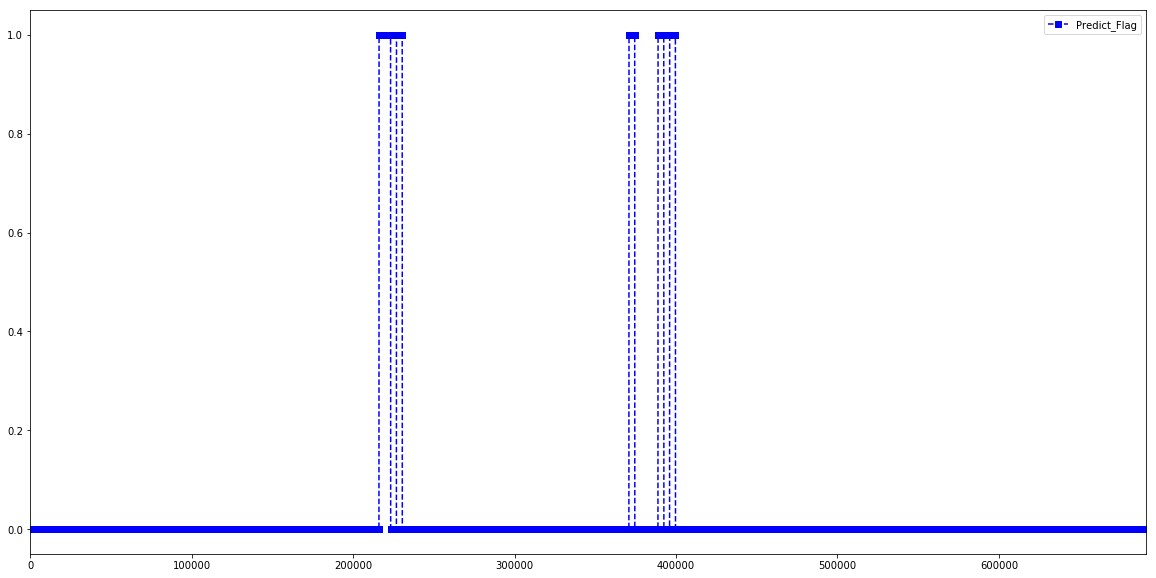

In [ ]:
y_predict_df = pd.DataFrame(predicted_flag_array[0:n_timesteps], columns=['Predict_Flag'])

y_predict_df.plot(style=['bs--'], figsize=(20,10))

In [ ]:
half_array = np.zeros(n_timesteps, dtype=np.float)
half_array.fill(0.5)
#print half_array
half_df = pd.DataFrame(half_array[0:n_timesteps], columns=['AUC = 0.5'])

upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
tuner2 = pd.concat([tuner, half_df], axis=1)
tuner3 = pd.concat([tuner2, upper_threshold_df], axis=1)
tuner3.plot(style=['bs--', '-', '-', '-'], figsize=(20,10))

In [ ]:
plt.figure(figsize=[50, 80])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

plt.show()

In [ ]:
half_array = np.zeros(n_timesteps, dtype=np.float)
half_array.fill(0.5)
#print half_array
#half_df = pd.DataFrame(half_array[0:n_timesteps], columns=['AUC = 0.5'])

upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
#tuner2 = pd.concat([tuner, half_df], axis=1)
tuner3 = pd.concat([tuner, upper_threshold_df], axis=1)
tuner3.plot(style=['bs--', '-', '-',], figsize=(20,10))